# Fit the diff color model for PWV

- author Sylvie Dagoret-Campagne
- creation date : 2024/09/10
- update : 2024/08/10

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cm as cmx
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os,sys
import re
import pandas as pd

from astropy.io import fits
from astropy import units as u
from astropy import constants as c

plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

import pickle
from scipy.interpolate import RegularGridInterpolator

import scipy
from scipy.optimize import curve_fit

In [2]:
machine_name = os.uname().nodename
path_rubinsimphot = "repos/repos_w_2024_17/rubinsimphot/src"
if 'sdf' in machine_name:
    #machine_name_usdf = 'sdfrome001'
    print("Set environment for USDF")
    newpythonpath = os.path.join(os.getenv("HOME"),path_rubinsimphot)
    sys.path.append(newpythonpath)
elif 'dagoret-nb' in machine_name:
    print("Set environment for USDF Rubin Science Platform")
    newpythonpath = os.path.join(os.getenv("HOME"),path_rubinsimphot)
    sys.path.append(newpythonpath)    
elif 'mac' in machine_name:
    print("Be sure to run this notebook in conda environment named conda_py310")
else:
    print(f"Your current machine name is {machine_name}. Check your python environment")

Be sure to run this notebook in conda environment named conda_py310


## Config

In [3]:
OBS_tag = "AUXTEL"
file0_out = f"{OBS_tag}_atmosphericzycolorgrid_params.pickle"
file1_out = f"{OBS_tag}_atmosphericzycolorgrid_datagrid.npy"

## Read files

In [4]:
with (open(file0_out, "rb")) as openfile:
    while True:
        try:
            info_params = pickle.load(openfile)
        except EOFError:
            break


In [5]:
info_params

{'OBS': 'AUXTEL',
 'PWVMIN': 0.0,
 'PWVMAX': 14.9,
 'NPWV': 150,
 'DPWV': 0.09999999999999964,
 'PWV': array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
         1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
         2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
         3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
         4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
         5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
         6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
         7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
         8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
         9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9,
        11. , 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12. ,
        12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13. , 13.1,
        13

In [6]:
all_pwv = info_params['PWV']
all_zycolordiff = info_params['ZYCOLDIFF']

In [7]:
datagrid = np.load(file1_out,mmap_mode=None, allow_pickle=False)
print(f"...... datagrid file {file1_out} read")

...... datagrid file AUXTEL_atmosphericzycolorgrid_datagrid.npy read


## Check the model

In [8]:
nx = len(all_pwv)
ny = len(all_zycolordiff)
xg, yg = np.meshgrid(all_pwv, all_zycolordiff , indexing='ij')

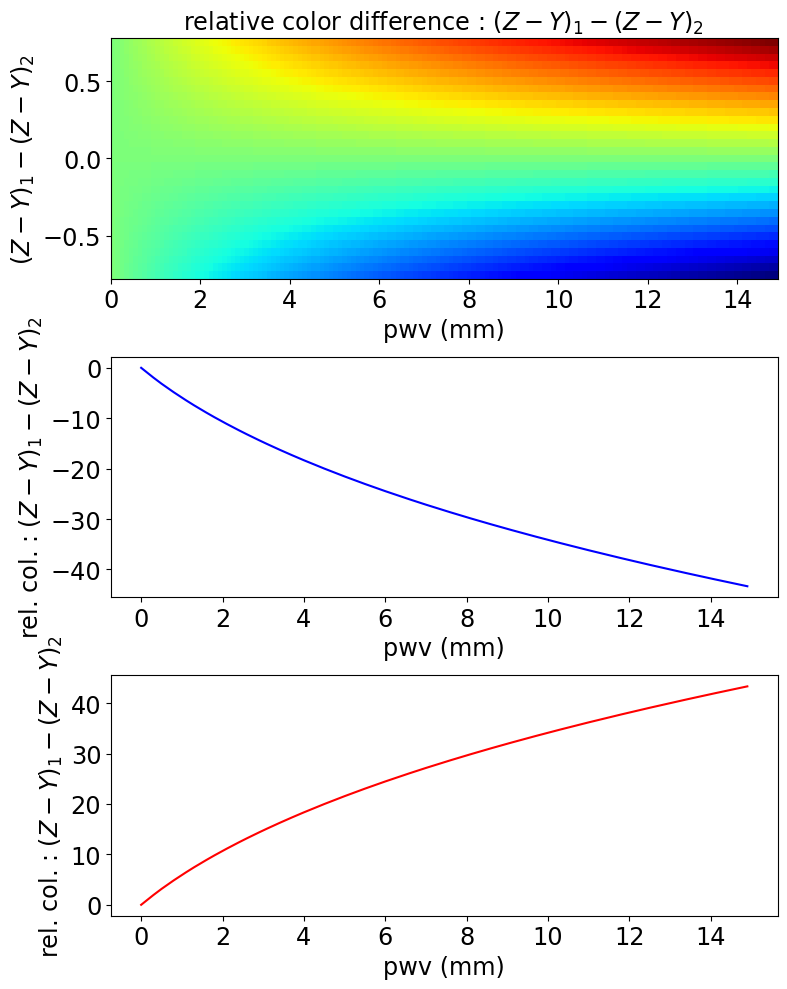

In [9]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(8,10))
im = ax1.imshow(datagrid,origin="lower",cmap="jet",
           extent=(all_pwv.min(),all_pwv.max(),all_zycolordiff.min(),all_zycolordiff.max()),aspect='auto')
#cbar

ax1.set_title("relative color difference : $(Z-Y)_1 - (Z-Y)_2$ ")
ax1.set_ylabel("$(Z-Y)_1-(Z-Y)_2$")
ax1.set_xlabel("pwv (mm)")
#ax1.set_aspect('auto')

ax2.plot(all_pwv, datagrid[0,:],'b-')
ax2.set_xlabel("pwv (mm)")
ax2.set_ylabel("rel. col. : $(Z-Y)_1 - (Z-Y)_2$")
ax3.plot(all_pwv, datagrid[-1,:],'r-')
ax3.set_xlabel("pwv (mm)")
ax3.set_ylabel("rel. col. : $(Z-Y)_1 - (Z-Y)_2$")

plt.tight_layout()
plt.show()

In [10]:
interp = RegularGridInterpolator((all_pwv, all_zycolordiff), datagrid.T, bounds_error=False, fill_value=None)

In [11]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = mpl.colors.Normalize(vmin=all_zycolordiff.min(), vmax=all_zycolordiff.max())
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

Text(0.5, 1.0, 'Relative color difference Z-Y from star1,star2')

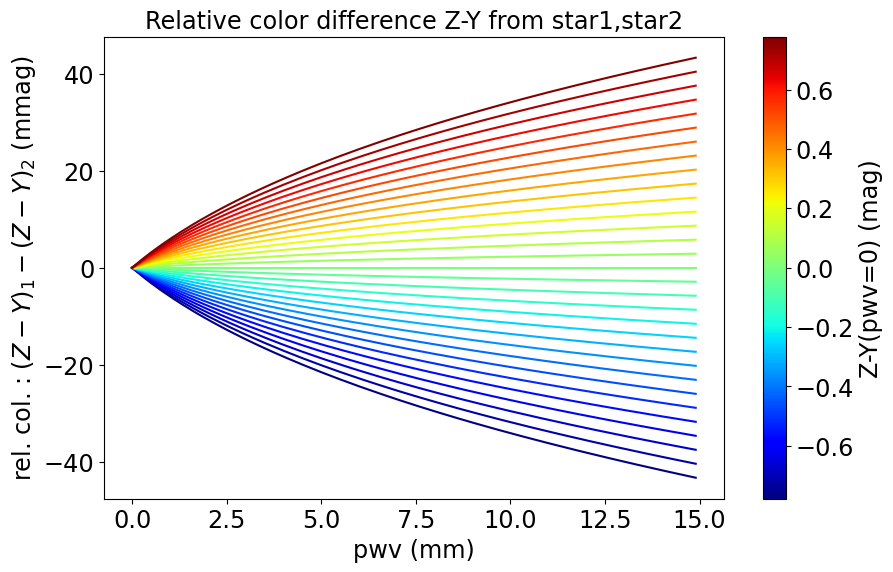

In [12]:
fig, ax = plt.subplots(1,1,figsize=(10,6))

for z_y0 in all_zycolordiff:
    the_color = scalarMap.to_rgba(z_y0, alpha=1)
    
    pts = list(zip(all_pwv,z_y0*np.ones(len(all_pwv))))  
    c = interp(pts)
    ax.plot(all_pwv,c,'-',c=the_color)
    
cbar = fig.colorbar(scalarMap,ax=ax, orientation='vertical', label='Z-Y(pwv=0) (mag)')    
ax.set_xlabel("pwv (mm)")    
#ax.set_ylabel("Czy1_Czy2_abmag_rel (mmag)")
ax.set_ylabel("rel. col. : $(Z-Y)_1 - (Z-Y)_2$ (mmag)")
ax.set_title("Relative color difference Z-Y from star1,star2")

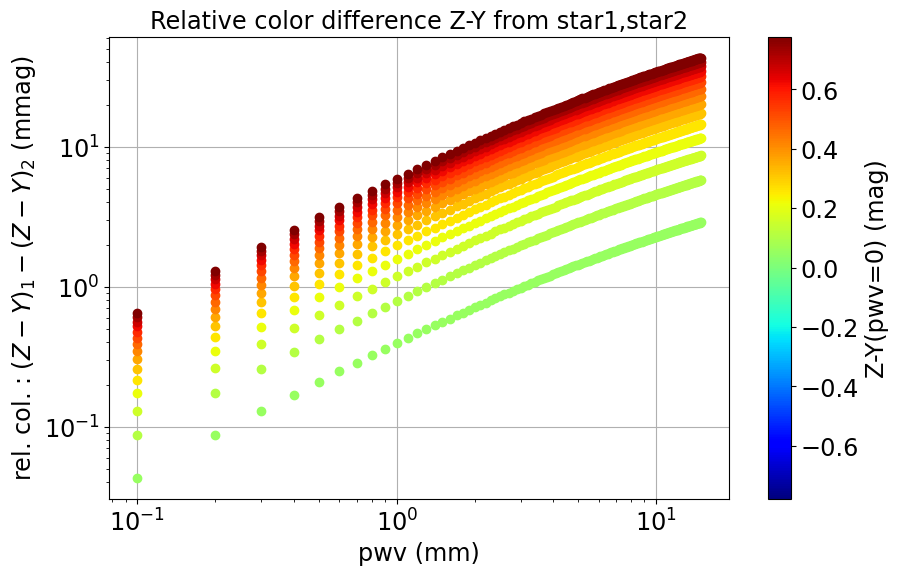

In [13]:
fig, ax = plt.subplots(1,1,figsize=(10,6))

for idx,z_y0 in enumerate(all_zycolordiff):
    the_color = scalarMap.to_rgba(z_y0, alpha=1)
    
    pts = list(zip(all_pwv,z_y0*np.ones(len(all_pwv))))  
    c = interp(pts)
    ax.plot(all_pwv,c,'o',lw=0.5,c=the_color)
    
    #p = np.polyfit(np.log(np.array(all_pwv)), np.log(np.abs(c)),deg=1) 
    #print(idx,z_y0,p)
    
cbar = fig.colorbar(scalarMap,ax=ax, orientation='vertical', label='Z-Y(pwv=0) (mag)')    
ax.set_xlabel("pwv (mm)")    
#ax.set_ylabel("Czy1_Czy2_abmag_rel (mmag)")
ax.set_ylabel("rel. col. : $(Z-Y)_1 - (Z-Y)_2$ (mmag)")
ax.set_title("Relative color difference Z-Y from star1,star2")
ax.set_yscale('log')
ax.set_xscale('log')
ax.grid()

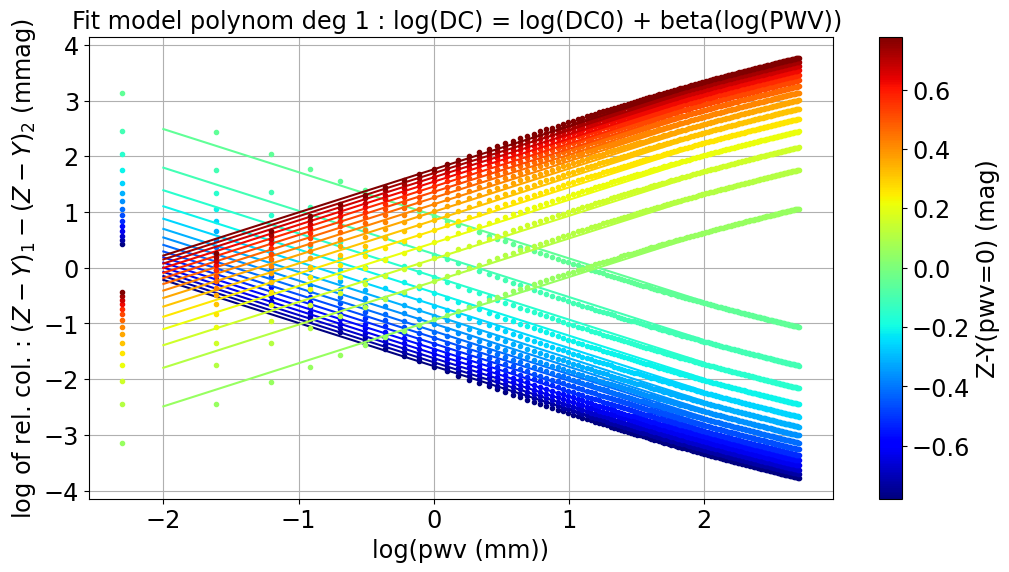

In [14]:
fig, ax = plt.subplots(1,1,figsize=(12,6))

all_p = []
all_sel_dc = []

for idx,z_y0 in enumerate(all_zycolordiff):
    the_color = scalarMap.to_rgba(z_y0, alpha=1)
    
    pts = list(zip(all_pwv,z_y0*np.ones(len(all_pwv))))  
    c = interp(pts)
    
    X = np.log(all_pwv[1:])
    
    csum = c[1:].sum()
    
    
    if csum>0 :
        Y = np.log(c[1:])
    elif csum<0 :
        Y = - np.log(-c[1:])
    else:
        Y = 0.0
        
    if csum != 0.0:    
        ax.plot(X,Y,'.',lw=0.5,c=the_color)
    
        z = np.polyfit(X,Y,deg=1) 
        pol = np.poly1d(z)
    
        xfit = np.linspace(-2,2,50)
        yfit = pol(xfit)
    
        plt.plot(xfit,yfit,'-',c=the_color)
        all_p.append(z)
        all_sel_dc.append(z_y0)
    
cbar = fig.colorbar(scalarMap,ax=ax, orientation='vertical', label='Z-Y(pwv=0) (mag)')    
ax.set_xlabel("log(pwv (mm))")    
#ax.set_ylabel("Czy1_Czy2_abmag_rel (mmag)")
ax.set_ylabel("log of rel. col. : $(Z-Y)_1 - (Z-Y)_2$ (mmag)")
ax.set_title("Fit model polynom deg 1 : log(DC) = log(DC0) + beta(log(PWV)) ")

ax.grid()

all_sel_dc = np.array(all_sel_dc)

In [15]:
all_sel_dc = np.reshape(all_sel_dc, (-1, 1))
all_sel_dc

array([[-0.77811671],
       [-0.72623009],
       [-0.67434599],
       [-0.62246423],
       [-0.57058462],
       [-0.51870699],
       [-0.46683116],
       [-0.41495695],
       [-0.36308418],
       [-0.31121267],
       [-0.25934224],
       [-0.20747271],
       [-0.15560391],
       [-0.10373564],
       [-0.05186773],
       [ 0.05186773],
       [ 0.10373564],
       [ 0.15560391],
       [ 0.20747271],
       [ 0.25934224],
       [ 0.31121267],
       [ 0.36308418],
       [ 0.41495695],
       [ 0.46683116],
       [ 0.51870699],
       [ 0.57058462],
       [ 0.62246423],
       [ 0.67434599],
       [ 0.72623009],
       [ 0.77811671]])

In [16]:
all_p = np.vstack(all_p)
all_p.shape

(30, 2)

In [17]:
fit_res = np.hstack([all_sel_dc,all_p])
fit_res

array([[-0.77811671, -0.77353646, -1.76535651],
       [-0.72623009, -0.77353836, -1.69651613],
       [-0.67434599, -0.77354012, -1.62255017],
       [-0.62246423, -0.77354175, -1.54263899],
       [-0.57058462, -0.77354325, -1.45574864],
       [-0.51870699, -0.77354461, -1.36054898],
       [-0.46683116, -0.77354585, -1.25528848],
       [-0.41495695, -0.77354696, -1.13759495],
       [-0.36308418, -0.77354793, -1.00414254],
       [-0.31121267, -0.77354878, -0.85006032],
       [-0.25934224, -0.7735495 , -0.6677967 ],
       [-0.20747271, -0.77355008, -0.44470055],
       [-0.15560391, -0.77355054, -0.15705535],
       [-0.10373564, -0.77355086,  0.24838341],
       [-0.05186773, -0.77355106,  0.94151479],
       [ 0.05186773,  0.77355106, -0.94151479],
       [ 0.10373564,  0.77355086, -0.24838341],
       [ 0.15560391,  0.77355054,  0.15705535],
       [ 0.20747271,  0.77355008,  0.44470055],
       [ 0.25934224,  0.7735495 ,  0.6677967 ],
       [ 0.31121267,  0.77354878,  0.850

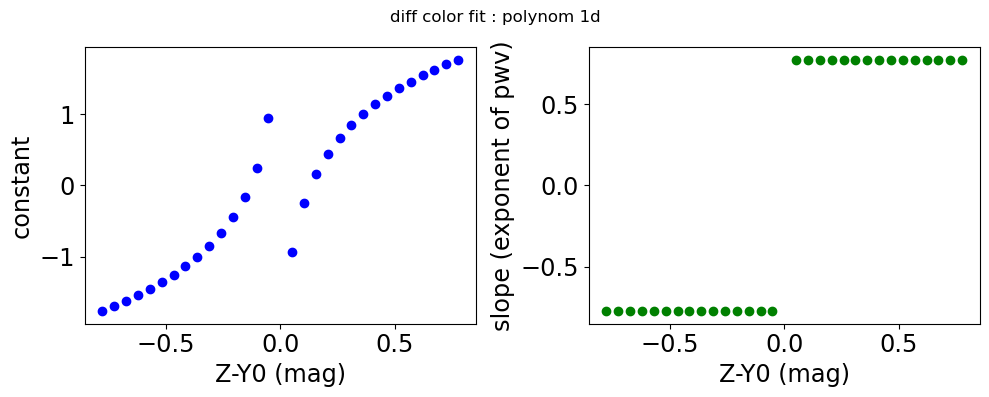

In [18]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
ax1.plot(fit_res[:,0],fit_res[:,2],'bo')
ax1.set_xlabel("Z-Y0 (mag)")
ax1.set_ylabel("constant")
ax2.plot(fit_res[:,0],fit_res[:,1],'go')
ax2.set_xlabel("Z-Y0 (mag)")
ax2.set_ylabel("slope (exponent of pwv)")
plt.suptitle("diff color fit : polynom 1d")
plt.tight_layout()

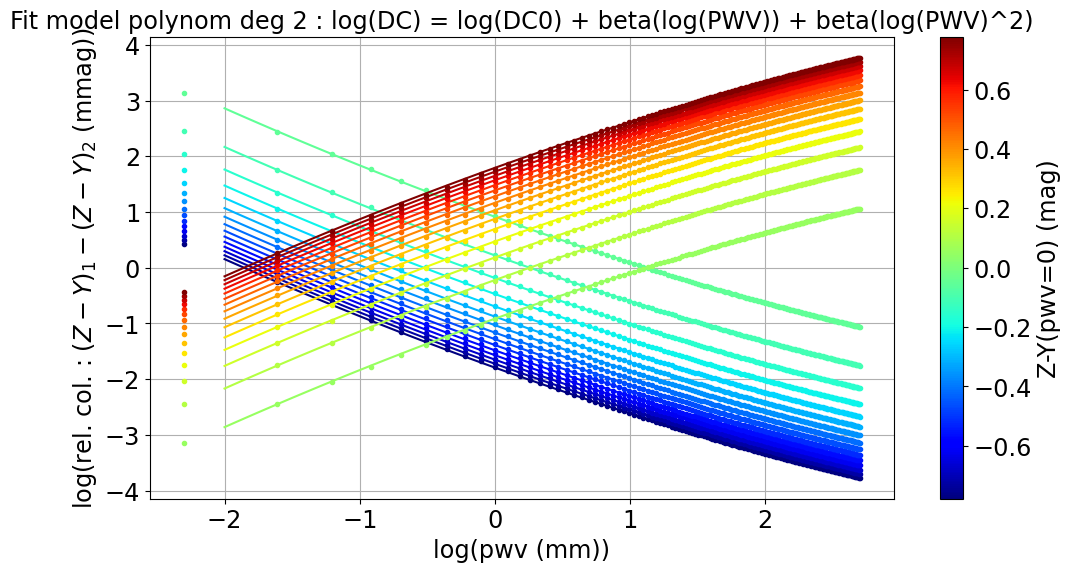

In [19]:
fig, ax = plt.subplots(1,1,figsize=(12,6))

all_p = []
all_sel_dc = []

for idx,z_y0 in enumerate(all_zycolordiff):
    the_color = scalarMap.to_rgba(z_y0, alpha=1)
    
    pts = list(zip(all_pwv,z_y0*np.ones(len(all_pwv))))  
    c = interp(pts)
    
    X = np.log(all_pwv[1:])
    csum = c[1:].sum()
    
    if csum>0 :
        Y = np.log(c[1:])
    elif csum<0 :
        Y = - np.log(-c[1:])
    else:
        Y = 0.0
        
    if csum != 0.0:    
        ax.plot(X,Y,'.',lw=0.5,c=the_color)
    
        z = np.polyfit(X,Y,deg=2) 
        pol = np.poly1d(z)
    
        xfit = np.linspace(-2,2,50)
        yfit = pol(xfit)
    
        plt.plot(xfit,yfit,'-',c=the_color)
        all_p.append(z)
        all_sel_dc.append(z_y0)
    
    

cbar = fig.colorbar(scalarMap,ax=ax, orientation='vertical', label='Z-Y(pwv=0) (mag)')    
ax.set_xlabel("log(pwv (mm))")    
#ax.set_ylabel("Czy1_Czy2_abmag_rel (mmag)")
ax.set_ylabel("log(rel. col. : $(Z-Y)_1 - (Z-Y)_2$ (mmag))")
ax.set_title("Fit model polynom deg 2 : log(DC) = log(DC0) + beta(log(PWV)) + beta(log(PWV)^2)")

ax.grid()
all_sel_dc = np.array(all_sel_dc)

In [20]:
all_sel_dc = np.reshape(all_sel_dc, (-1, 1))
all_sel_dc

array([[-0.77811671],
       [-0.72623009],
       [-0.67434599],
       [-0.62246423],
       [-0.57058462],
       [-0.51870699],
       [-0.46683116],
       [-0.41495695],
       [-0.36308418],
       [-0.31121267],
       [-0.25934224],
       [-0.20747271],
       [-0.15560391],
       [-0.10373564],
       [-0.05186773],
       [ 0.05186773],
       [ 0.10373564],
       [ 0.15560391],
       [ 0.20747271],
       [ 0.25934224],
       [ 0.31121267],
       [ 0.36308418],
       [ 0.41495695],
       [ 0.46683116],
       [ 0.51870699],
       [ 0.57058462],
       [ 0.62246423],
       [ 0.67434599],
       [ 0.72623009],
       [ 0.77811671]])

In [21]:
all_p = np.vstack(all_p)
all_p.shape

(30, 3)

In [22]:
fit_res = np.hstack([all_sel_dc,all_p])
fit_res

array([[-0.77811671,  0.05075807, -0.87162415, -1.79212125],
       [-0.72623009,  0.05075914, -0.87162812, -1.72328144],
       [-0.67434599,  0.05076014, -0.87163182, -1.64931601],
       [-0.62246423,  0.05076107, -0.87163524, -1.56940531],
       [-0.57058462,  0.05076192, -0.87163839, -1.48251541],
       [-0.51870699,  0.0507627 , -0.87164126, -1.38731617],
       [-0.46683116,  0.05076341, -0.87164386, -1.28205604],
       [-0.41495695,  0.05076404, -0.87164619, -1.16436284],
       [-0.36308418,  0.0507646 , -0.87164824, -1.03091073],
       [-0.31121267,  0.05076508, -0.87165002, -0.87682876],
       [-0.25934224,  0.05076549, -0.87165153, -0.69456535],
       [-0.20747271,  0.05076583, -0.87165276, -0.47146938],
       [-0.15560391,  0.05076609, -0.87165372, -0.18382432],
       [-0.10373564,  0.05076627, -0.8716544 ,  0.22161435],
       [-0.05186773,  0.05076638, -0.87165481,  0.91474567],
       [ 0.05186773, -0.05076638,  0.87165481, -0.91474567],
       [ 0.10373564, -0.

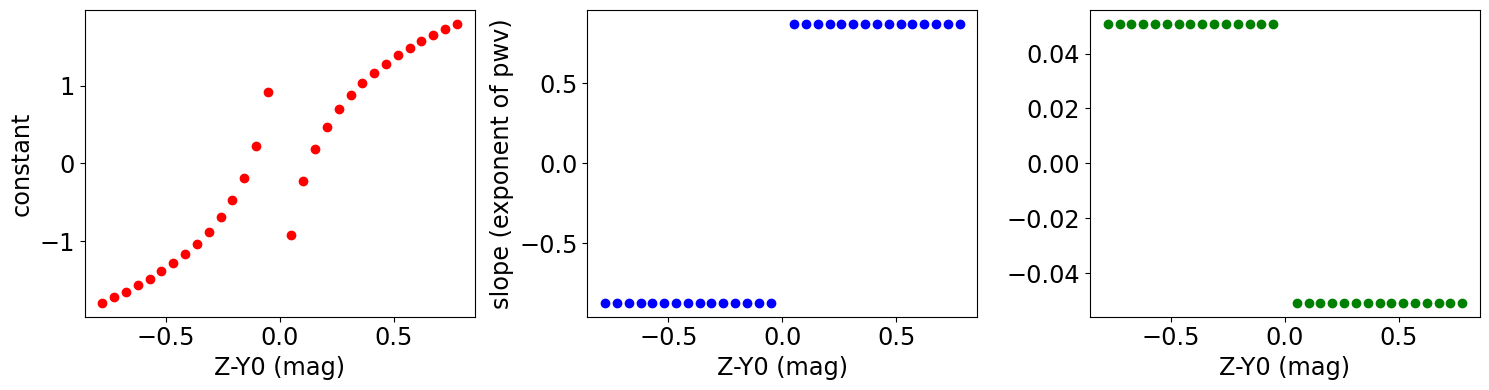

In [23]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,4))
ax1.plot(fit_res[:,0],fit_res[:,3],'ro')
ax1.set_xlabel("Z-Y0 (mag)")
ax1.set_ylabel("constant")
ax2.plot(fit_res[:,0],fit_res[:,2],'bo')
ax2.set_xlabel("Z-Y0 (mag)")
ax2.set_ylabel("slope (exponent of pwv")
ax3.plot(fit_res[:,0],fit_res[:,1],'go')
ax3.set_xlabel("Z-Y0 (mag)")
ax3.set_ylabel("")
plt.suptitle("diff color fit : polynom deg=2")
plt.tight_layout()